## Validation for Trained Model for ATE and AEC

In this notebook, a model path is used as input to 
1) load a fine-tuned GRACE Model for either ABSA or ABEA
2) pre-process the SemEval datasets (restaurant 2014, laptop 2014, and restaurant 2014, 2015 and 2016 union) according to the GRACE format
3) run an inference on the datasets
4) calculate recall, precision, f1 and accuracy metrics using two calculation methods:
    - exact and complete matches only: an inference (a found aspect term and emotion/ sentiment) are only counted as true positive if the start and end indices overlap with those in the labeled dataset
    - word-by-word: each word is compared between the labeled dataset and the inference - if a word is identified as an aspect term in both datasets, it is a true positive  

The first calculation will only capture a complete match between the inferred label and the label in the dataset, for example if the dataset contains the aspect term “first course”, only the complete inference “first course” would categorize as true positive, whereas only “course” would be a false positive. This calculation is a stricter assessment than the second calculation which assesses matching aspect terms in the model inference and the labeled dataset word for word. In that case the identification of only “course” would result in one false negative “first” and one true positive “course”. This calculation includes partial matches and gives an overview of the amount of aspect term words that were found.  



### Setup

In [273]:
import sys
sys.path.insert(0, 'GRACE/')                                        # Add 'GRACE/' directory at the start of the sys.path for module searching
import os                                                           # used to interact with the operating system

import torch                                                        # a deep learning framework for tensor computations and automatic differentiation
import torch.nn.functional as F                                     # torch.nn.functional is for activation and loss functions in pytorch
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler, TensorDataset # pytorch classes for data handling, sampling, batching etc.

import argparse                                                     # for parsing command line arguments
import random                                                       # to generate random numbers
import numpy as np                                                  # for numerical and array operations
import pandas as pd                                                 # for data manipulation and analysis

from tokenization import BertTokenizer                              # for tokenizing text into tokens understandable by BERT

# Import local files from the GRACE folder in this repo
from ate_asc_modeling_local_bert_file import BertForSequenceLabeling
import ate_asc_modeling_local_bert_file                             # local file containing BERT modeling utilities for ATE and ASC
from file_utils import PYTORCH_PRETRAINED_BERT_CACHE                # PYTORCH_PRETRAINED_BERT_CACHE to manage caching for pre-trained BERT models
from ate_asc_features import ATEASCProcessor, convert_examples_to_features, get_labels

from tqdm import tqdm                                               # for progress monitoring
import re

Choose which model will be evaluated using the SemEval Datasets

In [274]:
nameofrun = 'ABEA_with_0.25DO_0.05_weight_decay'
epoch = '8'

In [275]:
# Your device settings
device = "cuda"                                                 # else "cpu"
n_gpu = 1                                                       # nr. of GPUs being used

# -------------------------------------

path = f'GRACE/data/same_split_as_absa/out_{nameofrun}_ateacs/'
# path = "GRACE/data/same_split_as_absa/decoder_fine_tuning/"
model = 'pytorch_model.bin.' + epoch
# model = 'pytorch_model.bin.4'

# last result from the original settings with all the ABEA training data --USED IN APPLICATION CASE/ USE CASE FOR CALI
# model_path = 'GRACE/out_abea_ateacs/pytorch_model.bin.9'
# model_path = 'GRACE/data/same_split_as_absa/out_no_vat_ateacs/pytorch_model.bin.7'
model_path = path + model
print(model_path)


# -------------------------------------

# for emotions

data_directory = 'GRACE/data/same_split_as_absa/'

train='nouns_w_none_train.txt'
valid='nouns_w_none_trial.txt'
test='nouns_w_none_test.gold.txt'



# data_directory = 'GRACE/data/'

# # train='abea_train.txt'
# # valid='abea_trial.txt'
# # test='abea_test.gold.txt'




# # for sentiments
# train='twitter_1_train.txt'
# valid='twitter_1_trial.txt'
# test='twitter_1_test.gold.txt'

GRACE/data/same_split_as_absa/out_ABEA_with_0.25DO_0.05_weight_decay_ateacs/pytorch_model.bin.8


In [276]:
# # Load your GeoDataFrame
# tweets_intersecting_fires_gdf = gpd.read_file('Data/Case Study Data/tweets_intersecting_fires.shp')

# # Print the CRS and head to verify data
# print(tweets_intersecting_fires_gdf.crs)
# print(tweets_intersecting_fires_gdf.head())

# # Ensure the CRS is set correctly
# if tweets_intersecting_fires_gdf.crs is None:
#     tweets_intersecting_fires_gdf.set_crs(epsg=3857, inplace=True)

# # Convert the CRS to EPSG:4326 to verify coordinates
# tweets_intersecting_fires_gdf_geo = tweets_intersecting_fires_gdf.to_crs(epsg=4326)

# # Print the head to check the coordinates
# print(tweets_intersecting_fires_gdf_geo.head())

# # Plot the data without basemap to verify locations
# fig, ax = plt.subplots(figsize=(10, 10))
# tweets_intersecting_fires_gdf_geo.plot(ax=ax, marker='o', color='red', markersize=5, alpha=0.7, edgecolor='k')
# plt.title('Tweets Intersecting Fires (Geographic Coordinates)')
# plt.xlabel('Longitude')
# plt.ylabel('Latitude')
# plt.show()

# # Convert back to Web Mercator for plotting with basemap
# tweets_intersecting_fires_gdf = tweets_intersecting_fires_gdf_geo.to_crs(epsg=3857)

# # Create the plot with basemap
# fig, ax = plt.subplots(figsize=(10, 10))
# tweets_intersecting_fires_gdf.plot(ax=ax, marker='o', color='red', markersize=5, alpha=0.7, edgecolor='k')

# # Add basemap with a fixed zoom level
# ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik, zoom=10)

# # Set plot title and labels
# plt.title('Tweets Intersecting Fires with Basemap')
# plt.xlabel('Longitude')
# plt.ylabel('Latitude')

# # Show plot
# plt.show()

### Helper Functions

In [277]:
from collections import Counter

def count_emotion_words1(df):
    # Flatten the list of emotions into individual words
    all_emotions = []
    for emotions in df['aspect_emotions']:
        for emotion_phrase in emotions:
            # Split each phrase by spaces to handle repeated emotions and add to the list
            all_emotions.extend(emotion_phrase.split())

    # Use Counter to count occurrences of each word
    emotion_counts = Counter(all_emotions)

    return emotion_counts

def count_emotion_words2(df, column):
    # Flatten the list of emotions into individual words
    all_emotions = []
    for _, row in df.iterrows():
        # Split each phrase by spaces to handle repeated emotions and add to the list
        all_emotions.append(row[column])

    # Use Counter to count occurrences of each word
    emotion_counts = Counter(all_emotions)

    return emotion_counts

In [278]:
# function to read the GRACE-formatted txt file WITH EMOTIONS into a df with a 'text' and 'label' column.
def grace_format_to_df_cols(txt_path):

    with open(txt_path, 'r') as file:
        file_content = file.read()
    
    content_without_docstart = file_content.split('\n', 1)[1]

    # Split the content based on empty lines to get each sequence
    sequences = [seq.strip() for seq in content_without_docstart.split('\n\n') if seq.strip()]

    texts_labels = [process_sequence(seq) for seq in sequences]
    texts, labels = zip(*texts_labels)  # Unzip the texts and labels

    df = pd.DataFrame({
        'text': texts,
        'label': labels
    })

    return df

# function to process each of the sequences
def process_sequence(seq):
    words = []
    labels = []
    char_index = 0  # Start from the first character
    in_label = False
    label_start = 0
    label_sentiment = ''

    for line in seq.split('\n'):
        parts = line.split()
        if len(parts) < 2:  # Skip empty lines or lines without tags
            continue
        word, tag = parts[0], parts[-1]
        words.append(word)

        # If this word starts a new label
        if 'B_AP' in tag:
            if in_label:  # End the previous label if starting a new one
                labels.append([label_start, char_index - 1, label_sentiment])
            in_label = True
            label_start = char_index
            # Determine the emotion
            if 'FEAR' in tag:
                label_sentiment = 'FEAR'
            elif 'NONE' in tag:
                label_sentiment = 'NONE'
            elif 'HAPPINESS' in tag:
                label_sentiment = 'HAPPINESS'
            elif 'ANGER' in tag:
                label_sentiment = 'ANGER'
            elif 'SADNESS' in tag:
                label_sentiment = 'SADNESS'

        # If this word is not part of a label or starts a new label
        if 'B_AP' not in tag and 'I_AP' not in tag and in_label:
            labels.append([label_start, char_index - 1, label_sentiment])
            in_label = False

        char_index += len(word) + 1  # Update character index for next word, adding 1 for the space

    # If the last label goes till the end of the sequence
    if in_label:
        labels.append([label_start, char_index - 1, label_sentiment])

    return ' '.join(words), labels

### Load Model with Correct Labels and Training State

In [279]:
# set arguments required for model initialization
args = argparse.Namespace(
    data_dir=data_directory, 
    bert_model='bert-base-uncased',
    init_model=None,
    task_name="ate_asc",
    data_name="abea",
    train_file=train,
    valid_file=valid,
    test_file=test,
    output_dir='out_testing/',
    seed = 42,
    do_lower_case=True,
    local_rank=-1,
    eval_batch_size=32,
    max_seq_length=128,
    use_ghl=True, 
    use_vat=False, 
    use_decoder=True, 
    num_decoder_layer=2, 
    decoder_shared_layer=3)

random.seed(args.seed)
os.environ['PYTHONHASHSEED'] = str(args.seed)
np.random.seed(args.seed)
torch.manual_seed(args.seed)
torch.cuda.manual_seed(args.seed)
torch.cuda.manual_seed_all(args.seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

n_gpu = 1
data_name = args.data_name.lower()
task_name = args.task_name.lower()
task_config = {
    "use_ghl": True,
    "use_vat": False,
    "num_decoder_layer": 2,
    "decoder_shared_layer": 3,
}

In [280]:
# dataloader to preprocess the input data
def dataloader_val(args, tokenizer, file_path, label_tp_list, set_type="val"):

    dataset = ATEASCProcessor(file_path=file_path, set_type=set_type)
    print("Loaded val file: {}".format(file_path))

    eval_features = convert_examples_to_features(dataset.examples, label_tp_list,
                                                 args.max_seq_length, tokenizer, verbose_logging=False)

    all_input_ids = torch.tensor([f.input_ids for f in eval_features], dtype=torch.long)
    all_input_mask = torch.tensor([f.input_mask for f in eval_features], dtype=torch.long)
    all_segment_ids = torch.tensor([f.segment_ids for f in eval_features], dtype=torch.long)
    all_at_label_ids = torch.tensor([f.at_label_id for f in eval_features], dtype=torch.long)
    all_as_label_ids = torch.tensor([f.as_label_id for f in eval_features], dtype=torch.long)

    all_label_mask = torch.tensor([f.label_mask for f in eval_features], dtype=torch.long)
    all_label_mask_X = torch.tensor([f.label_mask_X for f in eval_features], dtype=torch.long)

    eval_data = TensorDataset(all_input_ids, all_input_mask, all_segment_ids, all_at_label_ids, all_as_label_ids,
                              all_label_mask, all_label_mask_X)

    # Run prediction for full data
    eval_sampler = SequentialSampler(eval_data)
    eval_dataloader = DataLoader(eval_data, sampler=eval_sampler, batch_size=args.eval_batch_size)

    return eval_dataloader, eval_data

# function to initialise the model using the model file (the .bin file), the correct labels, and settings
def load_model(model_file, args, num_tp_labels, task_config, device):
    model_file = model_file
    if os.path.exists(model_file):
        model_state_dict = torch.load(model_file, map_location='cpu')
        print("Model loaded from %s", model_file)
        model = BertForSequenceLabeling.from_pretrained(args.bert_model, cache_dir=PYTORCH_PRETRAINED_BERT_CACHE / 'distributed_{}'.format(args.local_rank),
                                                        state_dict=model_state_dict, num_tp_labels=num_tp_labels,
                                                        task_config=task_config)
        model.to(device)
        print("model to device")
    else:
        model = None
        print("model none")
    return model

In [281]:
# load bert tokenizer (bert-base-uncased)
tokenizer = BertTokenizer.from_pretrained(args.bert_model, do_lower_case=args.do_lower_case)

10/22/2024 22:12:37 - INFO - tokenization -   loading vocabulary file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased-vocab.txt from cache at C:\Users\chris\.pytorch_pretrained_bert\26bc1ad6c0ac742e9b52263248f6d0f00068293b33709fae12320c0e35ccfbbb.542ce4285a40d23a559526243235df47c5f75c197f04f37d1a0c124c32c9a084


In [282]:
file_path = os.path.join(args.data_dir, args.train_file)
print(f"Loading task specific labels from {file_path}")

# the ATEASCProcessor reads data and splits it into corpus and label list for ATE and ASC
dataset = ATEASCProcessor(file_path=file_path, set_type="train")
at_labels, as_labels = get_labels(dataset.label_tp_list)
label_tp_list = (at_labels, as_labels)

at_num_labels = len(label_tp_list[0])
as_num_labels = len(label_tp_list[1])
num_tp_labels = (at_num_labels, as_num_labels)

task_config["at_labels"] = label_tp_list[0]

at_label_list, as_label_list = label_tp_list
at_label_map = {i: label for i, label in enumerate(at_label_list)}
as_label_map = {i: label for i, label in enumerate(as_label_list)}

# print infos to double-check all is correct
print(f"ATE labels: {at_label_map}")
print(f"ASC labels: {as_label_map}")

Loading task specific labels from GRACE/data/same_split_as_absa/nouns_w_none_train.txt
ATE labels: {0: 'O', 1: 'B-AP', 2: 'I-AP'}
ASC labels: {0: 'O', 1: 'NONE', 2: 'FEAR', 3: 'SADNESS', 4: 'ANGER', 5: 'HAPPINESS'}


In [283]:
# an adapted ate_asc_modeling_local_bert_file.py is imported here, which loads the model from a folder in the repo ('GRACE/bert-base-uncased/bert-base-uncased.tar.gz')

model_file = model_path
model = load_model(model_file, args, num_tp_labels, task_config, device)

if hasattr(model, 'module'):
    print('has module')
    model = model.module

# set model to eval mode (turn off training features e.g. dropout)
model.eval()

Model loaded from %s GRACE/data/same_split_as_absa/out_ABEA_with_0.25DO_0.05_weight_decay_ateacs/pytorch_model.bin.8
loading archive file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased.tar.gz from cache at C:\Users\chris\.pytorch_pretrained_bert\distributed_-1\9c41111e2de84547a463fd39217199738d1e3deb72d4fec4399e6e241983c6f0.ae3cef932725ca7a30cdcb93fc6e09150a55e2a130ec7af63975a16c153ae2ba
extracting archive file C:\Users\chris\.pytorch_pretrained_bert\distributed_-1\9c41111e2de84547a463fd39217199738d1e3deb72d4fec4399e6e241983c6f0.ae3cef932725ca7a30cdcb93fc6e09150a55e2a130ec7af63975a16c153ae2ba to temp dir C:\Users\chris\AppData\Local\Temp\tmp74zwbpuq


10/22/2024 22:12:41 - INFO - decoder_module -   loading archive file c:\Users\chris\Documents\PLUS SharePoint\Universität Salzburg\AG_Geosocial Analytics Lab - MA - Christina Zorenböhmer\1 - Code\ABEA Repo\GRACE\decoder-bert-base


model to device


BertForSequenceLabeling(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): BertLayerNorm()
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): BertLayerNorm()
              (dropout): Dropout(p=0.1, inplace=False)
            )
  

### Run Model on ABEA Training Data


#### Load Data

In [284]:
# absa needs to be read properly from the GRACE formatting so that it can be converted to a df
training_data_preformatted = "GRACE/data/same_split_as_absa/abea_w_none_clean_train.txt"
abea_train = grace_format_to_df_cols(training_data_preformatted)

# turn into string format
# abea_train['label'] = abea_train['label'].astype(str)
# print(abea_train['label'].dtype)

print(len(abea_train))

1834


In [285]:
abea_train.loc[:6]

,text,label
0,This guy is bloody hilarious,"[[5, 8, HAPPINESS]]"
1,Kremlin critic Navalny says he is not afraid t...,"[[15, 22, NONE]]"
2,Chinook chuntering around outside !,"[[0, 18, NONE]]"
3,Directors Cut From My Tv Commercial Fire As He...,"[[22, 35, HAPPINESS]]"
4,Woolwich in the MUD #ArtetaIN,"[[0, 8, ANGER]]"
5,@jadiegray @latsondheimer A combination of bot...,"[[28, 39, NONE], [54, 58, SADNESS]]"
6,@Rovers @UmbroUK @RecoveriteAu Not sure the 94...,"[[55, 60, NONE]]"


In [286]:
training_data_preformatted = "GRACE/data/same_split_as_absa/abea_w_none_clean_train.txt"

DATALOADER_DICT = {}
# only "eval" state is needed ("train" is left out)
DATALOADER_DICT["ate_asc"] = {"eval":dataloader_val}
# Create dataloader with the prepared dataset
eval_dataloader, eval_examples = DATALOADER_DICT[task_name]["eval"](args, tokenizer, training_data_preformatted, label_tp_list=label_tp_list, set_type="val")

Loaded val file: GRACE/data/same_split_as_absa/abea_w_none_clean_train.txt


#### Run Model on the Prepared Data

In [287]:
# empty lists for both the identified aspect terms and the related emotions
pred_aspect_terms = []
pred_aspect_emotions = []

# for-loop to iterate over the preprocessed outputs from the "eval_dataloader" 
# for input_ids, input_mask, segment_ids, at_label_ids, as_label_ids, label_mask, label_mask_X in eval_dataloader:
for input_ids, input_mask, segment_ids, at_label_ids, as_label_ids, label_mask, label_mask_X in tqdm(eval_dataloader, desc="Evaluating"):
    input_ids = input_ids.to(device)
    input_mask = input_mask.to(device)
    segment_ids = segment_ids.to(device)
    at_label_ids = at_label_ids.to(device)
    as_label_ids = as_label_ids.to(device)
    label_mask = label_mask.to(device)
    label_mask_X = label_mask_X.to(device)
    
    with torch.no_grad():
        # logits, decoder_logits = model(input_ids, segment_ids, input_mask)
        logits, sequence_output, encoder_output = model.get_encoder_logits(input_ids, segment_ids, input_mask)
        pred_dec_ids = torch.argmax(F.log_softmax(logits, dim=2), dim=2)
        decoder_logits = model.get_decoder_logits(encoder_output, input_mask, label_mask_X, pred_dec_ids)
        logits = torch.argmax(F.log_softmax(logits, dim=2), dim=2)
        decoder_logits = torch.argmax(F.log_softmax(decoder_logits, dim=2), dim=2)
        logits = logits.detach().cpu().numpy()
        decoder_logits = decoder_logits.detach().cpu().numpy()
        
    at_label_ids = at_label_ids.to('cpu').numpy()
    as_label_ids = as_label_ids.to('cpu').numpy()
    label_mask = label_mask.to('cpu').numpy()
    
    for i, mask_i in enumerate(label_mask):
        temp_1 = []
        temp_2 = []
        for j, l in enumerate(mask_i):
            if l > -1:
                temp_1.append(at_label_map[logits[i][j]])
                temp_2.append(as_label_map[decoder_logits[i][j]])
                
        pred_aspect_terms.append(temp_1)
        pred_aspect_emotions.append(temp_2)

# add new aspect term labels and aspect sentiment labels as columns to twemlab dataframe
abea_train['aspect_term_preds'] = pred_aspect_terms
abea_train['aspect_emo_preds'] = pred_aspect_emotions

# ------------------------------------------------------------------------------
# Next step, extract the aspect term and sentiment 
aspect_terms = []
aspect_sentiments = []

# for every row (tweet)
for idx, row in abea_train.iterrows():
    
    row_aspect_terms = []
    row_aspect_sentiments = []

    # split text into individual words
    words = row['text'].split()

    # Loop through aspect_term_preds
    for i, pred in enumerate(row['aspect_term_preds']):
        if pred == 'B-AP':
            # Initialize term with the current word
            term = words[i] if i < len(words) else ''
            sent = row['aspect_emo_preds'][i]

            # check for continuation of aspect term ('I-AP')
            j = i + 1
            while j < len(row['aspect_term_preds']) and row['aspect_term_preds'][j] == 'I-AP':
                # Append word to term if within bounds
                if j < len(words):
                    term += ' ' + words[j]
                    sent += ' ' + row['aspect_emo_preds'][j]
                j += 1

            # save the aspect term and emotion
            if term:  # Only add non-empty terms
                row_aspect_terms.append(term)
                row_aspect_sentiments.append(sent)

    # append extracted terms and sentiments to respective lists
    aspect_terms.append(row_aspect_terms)
    aspect_sentiments.append(row_aspect_sentiments)

# assign the lists back to the DataFrame
abea_train['aspect_terms'] = aspect_terms
abea_train['aspect_emotions'] = aspect_sentiments

# remove the previous columns
abea_train.drop(columns=['aspect_term_preds', 'aspect_emo_preds'], inplace=True)

Evaluating: 100%|██████████| 58/58 [00:08<00:00,  6.84it/s]


#### View Results

In [288]:
abea_train.sample(5)

,text,label,aspect_terms,aspect_emotions
643,"Just a "" Casual Stroll "" with the dogs and hus...","[[9, 22, HAPPINESS], [64, 68, HAPPINESS]]","[Casual Stroll, dogs, husband, feet]","[NONE NONE, NONE, NONE, NONE]"
332,LACoFD- 5 | Antelope Valley Structure Fire rep...,"[[28, 42, NONE]]",[Structure Fire],[FEAR FEAR]
990,@BletchleyBark @GuruGryff Hoomum currently sea...,"[[26, 32, NONE], [53, 69, NONE]]",[electric fencing],[FEAR FEAR]
538,Can ' t wait 🙌,[],[],[]
1810,@AP #CrossfireHurricane .,"[[4, 23, NONE]]",[#CrossfireHurricane],[FEAR]


#### Calculate Precision, Recall, f1 on the Restaurants 2014 Dataset, on which the trained GRACE ABEA model has run

In [289]:
# from sklearn.metrics import precision_recall_fscore_support

# def extract_terms(text, indices):
#     terms = []
#     for index in indices:
#         start, end = index[0], index[1]
#         terms.append(text[start:end].strip())
#     return terms

# def calculate_metrics(df):
#     TP = 0
#     FP = 0
#     FN = 0
#     partial_matches = 0
    
#     for index, row in df.iterrows():
#         text = row['text']
#         labels = row['label']
#         ground_truth_terms = set([extract_terms(text, [label[:2]])[0] for label in labels if label]) if labels else set()
        
#         predicted_terms = set(row['aspect_terms'])

#         # Count True Positives (exact match)
#         TP += len(ground_truth_terms.intersection(predicted_terms))
        
#         # Count False Positives
#         FP += len(predicted_terms - ground_truth_terms)
        
#         # Count False Negatives
#         FN += len(ground_truth_terms - predicted_terms)

#         # Optionally handle partial matches
#         for pred_term in predicted_terms:
#             for gt_term in ground_truth_terms:
#                 if pred_term in gt_term or gt_term in pred_term:
#                     partial_matches += 1

#     # Calculate precision, recall, and F1 score
#     precision = TP / (TP + FP) if (TP + FP) > 0 else 0
#     recall = TP / (TP + FN) if (TP + FN) > 0 else 0
#     f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
    
#     print(f"TP: {TP}")
#     print(f"FP: {FP}")
#     print(f"FN {FN}")
#     print(f"Partial Matches: {partial_matches}")
#     return {
#         'Precision': precision,
#         'Recall': recall,
#         'F1 Score': f1,
#         'Partial Matches': partial_matches
#     }

# metrics = calculate_metrics(df_rest14)
# print(metrics)


In [290]:
# def extract_words(text, indices):
#     words = []
#     for index in indices:
#         start, end = index[0], index[1]
#         # Split the extracted term into words and extend the list
#         words.extend(text[start:end].strip().split())
#     return words

# def calculate_metrics(df):
#     TP = 0
#     FP = 0
#     FN = 0
    
#     for index, row in df.iterrows():
#         text = row['text']
#         labels = row['label']
#         # Extract all words from the ground truth terms
#         ground_truth_words = set(extract_words(text, [label[:2] for label in labels if label])) if labels else set()
#         # print(f"Labels: {ground_truth_words}")

#         # Extract all words from the predicted terms
#         predicted_words = set()
#         for term in row['aspect_terms']:
#             predicted_words.update(term.split())
#         # print(f"Predictions: {predicted_words}")

#         # Count True Positives (exact word match)
#         if not ground_truth_words and not predicted_words:
#             TP += 1  # Correctly predicted no terms
#             # print("TP: no aspect terms")
#         else:
#             TP += len(ground_truth_words.intersection(predicted_words))
#             # print(f"TP: {ground_truth_words.intersection(predicted_words)}")

#         # Count False Positives
#         FP += len(predicted_words - ground_truth_words)
#         # print(f"FP: {predicted_words - ground_truth_words}")

#         # Count False Negatives
#         FN += len(ground_truth_words - predicted_words)
#         # print(f"FN: {ground_truth_words - predicted_words}")

#         # print("-------")
        
#     # Calculate precision, recall, and F1 score
#     precision = TP / (TP + FP) if (TP + FP) > 0 else 0
#     recall = TP / (TP + FN) if (TP + FN) > 0 else 0
#     f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
    
#     return {
#         'Precision': round(precision, 4),
#         'Recall':  round(recall, 4),
#         'F1 Score': round(f1, 4)
#     }

# # Assuming 'df' is already defined and contains the columns 'text', 'label', and 'aspect_terms'
# metrics_rest14 = calculate_metrics(df_rest14)
# print(metrics_rest14)


### ATE Validation: Laptops 2014 SemEval Dataset

#### Load Data

In [291]:
# function to read the GRACE-formatted txt file into a df with a 'text' and 'label' column.
def grace_format_to_df_cols(txt_path):

    with open(txt_path, 'r') as file:
        file_content = file.read()
    
    content_without_docstart = file_content.split('\n', 1)[1]

    # Split the content based on empty lines to get each sequence
    sequences = [seq.strip() for seq in content_without_docstart.split('\n\n') if seq.strip()]

    texts_labels = [process_sequence(seq) for seq in sequences]
    texts, labels = zip(*texts_labels)  # Unzip the texts and labels

    df = pd.DataFrame({
        'text': texts,
        'label': labels
    })

    return df

# function to process each of the sequences
def process_sequence(seq):
    words = []
    labels = []
    char_index = 0  # Start from the first character
    in_label = False
    label_start = 0
    label_sentiment = ''

    for line in seq.split('\n'):
        parts = line.split()
        if len(parts) < 2:  # Skip empty lines or lines without tags
            continue
        word, tag = parts[0], parts[-1]
        words.append(word)

        # If this word starts a new label
        if 'B_AP' in tag:
            if in_label:  # End the previous label if starting a new one
                labels.append([label_start, char_index - 1, label_sentiment])
            in_label = True
            label_start = char_index
            # Determine the sentiment
            if 'NEUTRAL' in tag:
                label_sentiment = 'Neutral'
            elif 'POSITIVE' in tag:
                label_sentiment = 'Positive'
            elif 'NEGATIVE' in tag:
                label_sentiment = 'Negative'
                
        # If this word is not part of a label or starts a new label
        if 'B_AP' not in tag and 'I_AP' not in tag and in_label:
            labels.append([label_start, char_index - 1, label_sentiment])
            in_label = False

        char_index += len(word) + 1  # Update character index for next word, adding 1 for the space

    # If the last label goes till the end of the sequence
    if in_label:
        labels.append([label_start, char_index - 1, label_sentiment])

    return ' '.join(words), labels

In [292]:
# absa needs to be read properly from the GRACE formatting so that it can be converted to a df
file_path = "GRACE/data/laptops_2014_all.txt"
df_lap14 = grace_format_to_df_cols(file_path)

print(len(df_lap14))
df_lap14.head(5)

3845


,text,label
0,"Boot time is super fast , around anywhere from...","[[0, 9, Positive]]"
1,tech support would not fix the problem unless ...,"[[0, 12, Negative]]"
2,but in resume this computer rocks !,[]
3,Set up was easy .,"[[0, 6, Positive]]"
4,Did not enjoy the new Windows 8 and touchscree...,"[[22, 31, Negative], [36, 57, Negative]]"


In [293]:
# # Preprocess the data to fit the GRACE Model format

# # text column to list
# text_list = list(df_lap14['text'].astype(str))

# # input format for GRACE model
# addition = ' - - O O O'
# convert_to_doc = []

# # iteratively apply re-formatting and save to new list
# for tweet in text_list:
#     words = tweet.split()
#     words_with_addition = []
#     for word in words:
#         new_word = word + addition
#         #print(new_word)
#         words_with_addition.append(new_word)
#     convert_to_doc.append(words_with_addition)

# # Save in the Case study folder
# path_to_reformatted_data = "GRACE/data/laptops_2014_all_reformatted.txt"
# with open(path_to_reformatted_data, mode = "w", encoding='utf-8') as f:
#     f.write("-DOCSTART-\n\n")
#     for tweet in convert_to_doc:
#         for word in tweet:
#             f.write("%s\n" % word)
#         f.write("\n")

In [294]:
path_to_reformatted_data = "GRACE/data/laptops_2014_all_reformatted.txt"

DATALOADER_DICT = {}
# only "eval" state is needed ("train" is left out)
DATALOADER_DICT["ate_asc"] = {"eval":dataloader_val}
# Create dataloader with the prepared dataset
eval_dataloader, eval_examples = DATALOADER_DICT[task_name]["eval"](args, tokenizer, path_to_reformatted_data, label_tp_list=label_tp_list, set_type="val")

Loaded val file: GRACE/data/laptops_2014_all_reformatted.txt


#### Run Model on Prepared Dataset

In [295]:
# empty lists for both the identified aspect terms and the related emotions
pred_aspect_terms = []
pred_aspect_emotions = []

# for-loop to iterate over the preprocessed outputs from the "eval_dataloader" 
# for input_ids, input_mask, segment_ids, at_label_ids, as_label_ids, label_mask, label_mask_X in eval_dataloader:
for input_ids, input_mask, segment_ids, at_label_ids, as_label_ids, label_mask, label_mask_X in tqdm(eval_dataloader, desc="Evaluating"):
    input_ids = input_ids.to(device)
    input_mask = input_mask.to(device)
    segment_ids = segment_ids.to(device)
    at_label_ids = at_label_ids.to(device)
    as_label_ids = as_label_ids.to(device)
    label_mask = label_mask.to(device)
    label_mask_X = label_mask_X.to(device)
    
    with torch.no_grad():
        # logits, decoder_logits = model(input_ids, segment_ids, input_mask)
        logits, sequence_output, encoder_output = model.get_encoder_logits(input_ids, segment_ids, input_mask)
        pred_dec_ids = torch.argmax(F.log_softmax(logits, dim=2), dim=2)
        decoder_logits = model.get_decoder_logits(encoder_output, input_mask, label_mask_X, pred_dec_ids)
        logits = torch.argmax(F.log_softmax(logits, dim=2), dim=2)
        decoder_logits = torch.argmax(F.log_softmax(decoder_logits, dim=2), dim=2)
        logits = logits.detach().cpu().numpy()
        decoder_logits = decoder_logits.detach().cpu().numpy()
        
    at_label_ids = at_label_ids.to('cpu').numpy()
    as_label_ids = as_label_ids.to('cpu').numpy()
    label_mask = label_mask.to('cpu').numpy()
    
    for i, mask_i in enumerate(label_mask):
        temp_1 = []
        temp_2 = []
        for j, l in enumerate(mask_i):
            if l > -1:
                temp_1.append(at_label_map[logits[i][j]])
                temp_2.append(as_label_map[decoder_logits[i][j]])
                
        pred_aspect_terms.append(temp_1)
        pred_aspect_emotions.append(temp_2)

# add new aspect term labels and aspect sentiment labels as columns to twemlab dataframe
df_lap14['aspect_term_preds'] = pred_aspect_terms
df_lap14['aspect_emo_preds'] = pred_aspect_emotions

# ------------------------------------------------------------------------------
# Next step, extract the aspect term and sentiment and store in twemlab dataframe
aspect_terms = []
aspect_sentiments = []

# for every row (tweet)
for idx, row in df_lap14.iterrows():
    
    row_aspect_terms = []
    row_aspect_sentiments = []

    # split text into individual words
    words = row['text'].split()

    # Loop through aspect_term_preds
    for i, pred in enumerate(row['aspect_term_preds']):
        if pred == 'B-AP':
            # Initialize term with the current word
            term = words[i] if i < len(words) else ''
            sent = row['aspect_emo_preds'][i]

            # check for continuation of aspect term ('I-AP')
            j = i + 1
            while j < len(row['aspect_term_preds']) and row['aspect_term_preds'][j] == 'I-AP':
                # Append word to term if within bounds
                if j < len(words):
                    term += ' ' + words[j]
                    sent += ' ' + row['aspect_emo_preds'][j]
                j += 1

            # save the aspect term and emotion
            if term:  # Only add non-empty terms
                row_aspect_terms.append(term)
                row_aspect_sentiments.append(sent)

    # append extracted terms and sentiments to respective lists
    aspect_terms.append(row_aspect_terms)
    aspect_sentiments.append(row_aspect_sentiments)

# assign the lists back to the DataFrame
df_lap14['aspect_terms'] = aspect_terms
df_lap14['aspect_emotions'] = aspect_sentiments

# remove the previous columns
df_lap14.drop(columns=['aspect_term_preds', 'aspect_emo_preds'], inplace=True)

Evaluating: 100%|██████████| 121/121 [00:17<00:00,  6.97it/s]


#### View Results

In [296]:
df_lap14.sample(5)

,text,label,aspect_terms,aspect_emotions
3166,"I love the solid machined aluminum frame , and...","[[17, 40, Positive], [51, 59, Positive]]","[aluminum frame, keyboard, laptop]","[NONE NONE, NONE, NONE]"
3400,I bought this eMachines Notebook PC in January...,[],"[eMachines, Notebook PC, it]","[FEAR, FEAR FEAR, FEAR]"
8,No installation disk -LRB- DVD -RRB- is includ...,"[[3, 36, Neutral]]",[installation disk],[FEAR FEAR]
345,Thanks for the fast shipment and great price .,"[[20, 28, Positive], [39, 44, Positive]]","[shipment, price]","[NONE, NONE]"
1620,The computer runs very fast with no problems a...,"[[13, 17, Positive], [53, 67, Positive], [93, ...","[computer, iLife software, iMovie, GarageBand]","[NONE, NONE NONE, NONE, NONE]"


#### Calculate Precision, Recall, f1 on the Laptops 2014 Dataset, on which the trained GRACE ABEA model has run

In [297]:
from sklearn.metrics import precision_recall_fscore_support

def extract_terms(text, indices):
    terms = []
    for index in indices:
        start, end = index[0], index[1]
        terms.append(text[start:end].strip())
    return terms

def calculate_metrics(df):
    TP = 0
    FP = 0
    FN = 0
    partial_matches = 0
    
    for index, row in df.iterrows():
        text = row['text']
        labels = row['label']
        ground_truth_terms = set([extract_terms(text, [label[:2]])[0] for label in labels if label]) if labels else set()
        
        predicted_terms = set(row['aspect_terms'])

        # Count True Positives (exact match)
        TP += len(ground_truth_terms.intersection(predicted_terms))
        
        # Count False Positives
        FP += len(predicted_terms - ground_truth_terms)
        
        # Count False Negatives
        FN += len(ground_truth_terms - predicted_terms)

        # Optionally handle partial matches
        for pred_term in predicted_terms:
            for gt_term in ground_truth_terms:
                if pred_term in gt_term or gt_term in pred_term:
                    partial_matches += 1

    # Calculate precision, recall, and F1 score
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
    
    print(f"TP: {TP}")
    print(f"FP: {FP}")
    print(f"FN {FN}")
    print(f"Partial Matches: {partial_matches}")
    return {
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'Partial Matches': partial_matches
    }

metrics = calculate_metrics(df_lap14)
print(metrics)


TP: 1810
FP: 5720
FN 1143
Partial Matches: 2188
{'Precision': 0.2403718459495352, 'Recall': 0.6129359972908907, 'F1 Score': 0.34532099589812076, 'Partial Matches': 2188}


In [298]:
def extract_words(text, indices):
    words = []
    for index in indices:
        start, end = index[0], index[1]
        # Split the extracted term into words and extend the list
        words.extend(text[start:end].strip().split())
    return words

def calculate_metrics(df):
    TP = 0
    FP = 0
    FN = 0
    
    for index, row in df.iterrows():
        text = row['text']
        labels = row['label']
        # Extract all words from the ground truth terms
        ground_truth_words = set(extract_words(text, [label[:2] for label in labels if label])) if labels else set()
        # print(f"Labels: {ground_truth_words}")

        # Extract all words from the predicted terms
        predicted_words = set()
        for term in row['aspect_terms']:
            predicted_words.update(term.split())
        # print(f"Predictions: {predicted_words}")

        # Count True Positives (exact word match)
        if not ground_truth_words and not predicted_words:
            TP += 1  # Correctly predicted no terms
            # print("TP: no aspect terms")
        else:
            TP += len(ground_truth_words.intersection(predicted_words))
            # print(f"TP: {ground_truth_words.intersection(predicted_words)}")

        # Count False Positives
        FP += len(predicted_words - ground_truth_words)
        # print(f"FP: {predicted_words - ground_truth_words}")

        # Count False Negatives
        FN += len(ground_truth_words - predicted_words)
        # print(f"FN: {ground_truth_words - predicted_words}")

        # print("-------")
        
    # Calculate precision, recall, and F1 score
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
    
    return {
        'Precision': round(precision, 4),
        'Recall':  round(recall, 4),
        'F1 Score': round(f1, 4)
    }

# Assuming 'df' is already defined and contains the columns 'text', 'label', and 'aspect_terms'
metrics_lap14 = calculate_metrics(df_lap14)
print(metrics_lap14)


{'Precision': 0.3265, 'Recall': 0.6879, 'F1 Score': 0.4428}


### ATE Validation: Restaurants Union SemEval Dataset

#### Load data

In [299]:
# function to read the GRACE-formatted txt file into a df with a 'text' and 'label' column.
def grace_format_to_df_cols(txt_path):

    with open(txt_path, 'r') as file:
        file_content = file.read()
    
    content_without_docstart = file_content.split('\n', 1)[1]

    # Split the content based on empty lines to get each sequence
    sequences = [seq.strip() for seq in content_without_docstart.split('\n\n') if seq.strip()]

    texts_labels = [process_sequence(seq) for seq in sequences]
    texts, labels = zip(*texts_labels)  # Unzip the texts and labels

    df = pd.DataFrame({
        'text': texts,
        'label': labels
    })

    return df

# function to process each of the sequences
def process_sequence(seq):
    words = []
    labels = []
    char_index = 0  # Start from the first character
    in_label = False
    label_start = 0
    label_sentiment = ''

    for line in seq.split('\n'):
        parts = line.split()
        if len(parts) < 2:  # Skip empty lines or lines without tags
            continue
        word, tag = parts[0], parts[-1]
        words.append(word)

        # If this word starts a new label
        if 'B_AP' in tag:
            if in_label:  # End the previous label if starting a new one
                labels.append([label_start, char_index - 1, label_sentiment])
            in_label = True
            label_start = char_index
            # Determine the sentiment
            if 'NEUTRAL' in tag:
                label_sentiment = 'Neutral'
            elif 'POSITIVE' in tag:
                label_sentiment = 'Positive'
            elif 'NEGATIVE' in tag:
                label_sentiment = 'Negative'
                
        # If this word is not part of a label or starts a new label
        if 'B_AP' not in tag and 'I_AP' not in tag and in_label:
            labels.append([label_start, char_index - 1, label_sentiment])
            in_label = False

        char_index += len(word) + 1  # Update character index for next word, adding 1 for the space

    # If the last label goes till the end of the sequence
    if in_label:
        labels.append([label_start, char_index - 1, label_sentiment])

    return ' '.join(words), labels

In [300]:
# absa needs to be read properly from the GRACE formatting so that it can be converted to a df
file_path = "GRACE/data/restaurants_union_all.txt"
df_rest_all = grace_format_to_df_cols(file_path)

print(len(df_rest_all))
df_rest_all.head(5)

7286


,text,label
0,The bread is top notch as well .,"[[4, 9, Positive]]"
1,I have to say they have one of the fastest del...,"[[43, 57, Positive]]"
2,Food is always fresh and hot - ready to eat !,"[[0, 4, Positive]]"
3,Did I mention that the coffee is OUTSTANDING ?,"[[23, 29, Positive]]"
4,"Certainly not the best sushi in New York , how...","[[23, 28, ], [82, 87, Positive]]"


In [301]:
# # Preprocess the data to fit the GRACE Model format

# # text column to list
# text_list = list(df_rest_all['text'].astype(str))

# # input format for GRACE model
# addition = ' - - O O O'
# convert_to_doc = []

# # iteratively apply re-formatting and save to new list
# for tweet in text_list:
#     words = tweet.split()
#     words_with_addition = []
#     for word in words:
#         new_word = word + addition
#         #print(new_word)
#         words_with_addition.append(new_word)
#     convert_to_doc.append(words_with_addition)

# # Save in the Case study folder
# path_to_reformatted_data = "GRACE/data/restaurants_union_all_reformatted.txt"
# with open(path_to_reformatted_data, mode = "w", encoding='utf-8') as f:
#     f.write("-DOCSTART-\n\n")
#     for tweet in convert_to_doc:
#         for word in tweet:
#             f.write("%s\n" % word)
#         f.write("\n")

In [302]:
path_to_reformatted_data = "GRACE/data/restaurants_union_all_reformatted.txt"


DATALOADER_DICT = {}
# only "eval" state is needed ("train" is left out)
DATALOADER_DICT["ate_asc"] = {"eval":dataloader_val}
# Create dataloader with the prepared dataset
eval_dataloader, eval_examples = DATALOADER_DICT[task_name]["eval"](args, tokenizer, path_to_reformatted_data, label_tp_list=label_tp_list, set_type="val")

Loaded val file: GRACE/data/restaurants_union_all_reformatted.txt


#### Run Model on Prepared Dataset

In [303]:
# empty lists for both the identified aspect terms and the related emotions
pred_aspect_terms = []
pred_aspect_emotions = []

# for-loop to iterate over the preprocessed outputs from the "eval_dataloader" 
# for input_ids, input_mask, segment_ids, at_label_ids, as_label_ids, label_mask, label_mask_X in eval_dataloader:
for input_ids, input_mask, segment_ids, at_label_ids, as_label_ids, label_mask, label_mask_X in tqdm(eval_dataloader, desc="Evaluating"):
    input_ids = input_ids.to(device)
    input_mask = input_mask.to(device)
    segment_ids = segment_ids.to(device)
    at_label_ids = at_label_ids.to(device)
    as_label_ids = as_label_ids.to(device)
    label_mask = label_mask.to(device)
    label_mask_X = label_mask_X.to(device)
    
    with torch.no_grad():
        # logits, decoder_logits = model(input_ids, segment_ids, input_mask)
        logits, sequence_output, encoder_output = model.get_encoder_logits(input_ids, segment_ids, input_mask)
        pred_dec_ids = torch.argmax(F.log_softmax(logits, dim=2), dim=2)
        decoder_logits = model.get_decoder_logits(encoder_output, input_mask, label_mask_X, pred_dec_ids)
        logits = torch.argmax(F.log_softmax(logits, dim=2), dim=2)
        decoder_logits = torch.argmax(F.log_softmax(decoder_logits, dim=2), dim=2)
        logits = logits.detach().cpu().numpy()
        decoder_logits = decoder_logits.detach().cpu().numpy()
        
    at_label_ids = at_label_ids.to('cpu').numpy()
    as_label_ids = as_label_ids.to('cpu').numpy()
    label_mask = label_mask.to('cpu').numpy()
    
    for i, mask_i in enumerate(label_mask):
        temp_1 = []
        temp_2 = []
        for j, l in enumerate(mask_i):
            if l > -1:
                temp_1.append(at_label_map[logits[i][j]])
                temp_2.append(as_label_map[decoder_logits[i][j]])
                
        pred_aspect_terms.append(temp_1)
        pred_aspect_emotions.append(temp_2)

# add new aspect term labels and aspect sentiment labels as columns to twemlab dataframe
df_rest_all['aspect_term_preds'] = pred_aspect_terms
df_rest_all['aspect_emo_preds'] = pred_aspect_emotions

# ------------------------------------------------------------------------------
# Next step, extract the aspect term and sentiment and store in twemlab dataframe
aspect_terms = []
aspect_sentiments = []

# for every row (tweet)
for idx, row in df_rest_all.iterrows():
    
    row_aspect_terms = []
    row_aspect_sentiments = []

    # split text into individual words
    words = row['text'].split()

    # Loop through aspect_term_preds
    for i, pred in enumerate(row['aspect_term_preds']):
        if pred == 'B-AP':
            # Initialize term with the current word
            term = words[i] if i < len(words) else ''
            sent = row['aspect_emo_preds'][i]

            # check for continuation of aspect term ('I-AP')
            j = i + 1
            while j < len(row['aspect_term_preds']) and row['aspect_term_preds'][j] == 'I-AP':
                # Append word to term if within bounds
                if j < len(words):
                    term += ' ' + words[j]
                    sent += ' ' + row['aspect_emo_preds'][j]
                j += 1

            # save the aspect term and emotion
            if term:  # Only add non-empty terms
                row_aspect_terms.append(term)
                row_aspect_sentiments.append(sent)

    # append extracted terms and sentiments to respective lists
    aspect_terms.append(row_aspect_terms)
    aspect_sentiments.append(row_aspect_sentiments)

# assign the lists back to the DataFrame
df_rest_all['aspect_terms'] = aspect_terms
df_rest_all['aspect_emotions'] = aspect_sentiments

# remove the previous columns
df_rest_all.drop(columns=['aspect_term_preds', 'aspect_emo_preds'], inplace=True)

Evaluating: 100%|██████████| 228/228 [00:34<00:00,  6.70it/s]


#### View Results

In [304]:
df_rest_all.sample(5)

,text,label,aspect_terms,aspect_emotions
1688,The band was very good and the service was att...,"[[4, 8, Positive], [31, 38, Positive]]","[band, service]","[NONE, NONE]"
7253,For dinner I had the chicken tikka-masala and ...,[],"[chicken tikka-masala, garlic naan]","[NONE NONE, NONE NONE]"
5331,Over 100 different choices to create your own .,[],[choices],[NONE]
1697,"The sommelier is fantastic , down-to-earth , &...","[[4, 13, Positive]]",[sommelier],[NONE]
649,The food was good overall .,"[[4, 8, Positive]]",[food],[NONE]


#### Calculate Metrics

In [305]:
from sklearn.metrics import precision_recall_fscore_support

def extract_terms(text, indices):
    terms = []
    for index in indices:
        start, end = index[0], index[1]
        terms.append(text[start:end].strip())
    return terms

def calculate_metrics(df):
    TP = 0
    FP = 0
    FN = 0
    partial_matches = 0
    
    for index, row in df.iterrows():
        text = row['text']
        labels = row['label']
        ground_truth_terms = set([extract_terms(text, [label[:2]])[0] for label in labels if label]) if labels else set()
        
        predicted_terms = set(row['aspect_terms'])

        # Count True Positives (exact match)
        TP += len(ground_truth_terms.intersection(predicted_terms))
        
        # Count False Positives
        FP += len(predicted_terms - ground_truth_terms)
        
        # Count False Negatives
        FN += len(ground_truth_terms - predicted_terms)

        # Optionally handle partial matches
        for pred_term in predicted_terms:
            for gt_term in ground_truth_terms:
                if pred_term in gt_term or gt_term in pred_term:
                    partial_matches += 1

    # Calculate precision, recall, and F1 score
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
    
    print(f"TP: {TP}")
    print(f"FP: {FP}")
    print(f"FN {FN}")
    print(f"Partial Matches: {partial_matches}")
    return {
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'Partial Matches': partial_matches
    }

metrics = calculate_metrics(df_rest_all)
print(metrics)


TP: 6151
FP: 8620
FN 1517
Partial Matches: 7238
{'Precision': 0.4164240741994449, 'Recall': 0.8021648408972353, 'F1 Score': 0.5482419002629351, 'Partial Matches': 7238}


In [306]:
def extract_words(text, indices):
    words = []
    for index in indices:
        start, end = index[0], index[1]
        # Split the extracted term into words and extend the list
        words.extend(text[start:end].strip().split())
    return words

def calculate_metrics(df):
    TP = 0
    FP = 0
    FN = 0
    
    for index, row in df.iterrows():
        text = row['text']
        labels = row['label']
        # Extract all words from the ground truth terms
        ground_truth_words = set(extract_words(text, [label[:2] for label in labels if label])) if labels else set()
        # print(f"Labels: {ground_truth_words}")

        # Extract all words from the predicted terms
        predicted_words = set()
        for term in row['aspect_terms']:
            predicted_words.update(term.split())
        # print(f"Predictions: {predicted_words}")

        # Count True Positives (exact word match)
        if not ground_truth_words and not predicted_words:
            TP += 1  # Correctly predicted no terms
            # print("TP: no aspect terms")
        else:
            TP += len(ground_truth_words.intersection(predicted_words))
            # print(f"TP: {ground_truth_words.intersection(predicted_words)}")

        # Count False Positives
        FP += len(predicted_words - ground_truth_words)
        # print(f"FP: {predicted_words - ground_truth_words}")

        # Count False Negatives
        FN += len(ground_truth_words - predicted_words)
        # print(f"FN: {ground_truth_words - predicted_words}")

        # print("-------")
        
    # Calculate precision, recall, and F1 score
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
    
    return {
        'Precision': round(precision, 4),
        'Recall':  round(recall, 4),
        'F1 Score': round(f1, 4)
    }

# Assuming 'df' is already defined and contains the columns 'text', 'label', and 'aspect_terms'
metrics_rest_all = calculate_metrics(df_rest_all)
print(metrics_rest_all)


{'Precision': 0.5, 'Recall': 0.8338, 'F1 Score': 0.6251}


### Emotion Validation: SemEval2018 Affect

In [307]:
# load data
df_affect = pd.read_csv("GRACE/data/SemEval Affect EI-reg/EI-reg-En-all.tsv", sep="\t")
print(len(df_affect))

12634


In [308]:
df_affect = df_affect.sample(frac=1).reset_index(drop=True)
df_affect.head()

,ID,Tweet,Affect Dimension,Intensity Score
0,2018-En-01346,"Life is too short to be jealous, hating, keepi...",fear,0.500
1,2018-En-03526,@stephdavis77 Your parents should get you help...,fear,0.854
2,2017-En-30164,@jimadair3 Guitar shop owners everywhere rejoice,joy,0.667
3,2017-En-41513,Sometimes the support network is causing the d...,sadness,0.854
4,2018-En-00995,'....trying to work out how a band featuring C...,sadness,0.739


In [309]:
# # Preprocess the data to fit the GRACE Model format

# # text column to list
# text_list = list(df_affect['Tweet'].astype(str))

# # input format for GRACE model
# addition = ' - - O O O'
# convert_to_doc = []

# # iteratively apply re-formatting and save to new list
# for tweet in text_list:
#     words = tweet.split()
#     words_with_addition = []
#     for word in words:
#         new_word = word + addition
#         #print(new_word)
#         words_with_addition.append(new_word)
#     convert_to_doc.append(words_with_addition)

# # Save in the Case study folder
# path_to_reformatted_data = "GRACE/data/semeval_affect_reformatted.txt"
# with open(path_to_reformatted_data, mode = "w", encoding='utf-8') as f:
#     f.write("-DOCSTART-\n\n")
#     for tweet in convert_to_doc:
#         for word in tweet:
#             f.write("%s\n" % word)
#         f.write("\n")

In [310]:
path_to_reformatted_data = "GRACE/data/semeval_affect_reformatted.txt"

DATALOADER_DICT = {}
# only "eval" state is needed ("train" is left out)
DATALOADER_DICT["ate_asc"] = {"eval":dataloader_val}
# Create dataloader with the prepared dataset
eval_dataloader, eval_examples = DATALOADER_DICT[task_name]["eval"](args, tokenizer, path_to_reformatted_data, label_tp_list=label_tp_list, set_type="val")

Loaded val file: GRACE/data/semeval_affect_reformatted.txt


In [311]:
# empty lists for both the identified aspect terms and the related emotions
pred_aspect_terms = []
pred_aspect_emotions = []

# for-loop to iterate over the preprocessed outputs from the "eval_dataloader" 
# for input_ids, input_mask, segment_ids, at_label_ids, as_label_ids, label_mask, label_mask_X in eval_dataloader:
for input_ids, input_mask, segment_ids, at_label_ids, as_label_ids, label_mask, label_mask_X in tqdm(eval_dataloader, desc="Evaluating"):
    input_ids = input_ids.to(device)
    input_mask = input_mask.to(device)
    segment_ids = segment_ids.to(device)
    at_label_ids = at_label_ids.to(device)
    as_label_ids = as_label_ids.to(device)
    label_mask = label_mask.to(device)
    label_mask_X = label_mask_X.to(device)
    
    with torch.no_grad():
        # logits, decoder_logits = model(input_ids, segment_ids, input_mask)
        logits, sequence_output, encoder_output = model.get_encoder_logits(input_ids, segment_ids, input_mask)
        pred_dec_ids = torch.argmax(F.log_softmax(logits, dim=2), dim=2)
        decoder_logits = model.get_decoder_logits(encoder_output, input_mask, label_mask_X, pred_dec_ids)
        logits = torch.argmax(F.log_softmax(logits, dim=2), dim=2)
        decoder_logits = torch.argmax(F.log_softmax(decoder_logits, dim=2), dim=2)
        logits = logits.detach().cpu().numpy()
        decoder_logits = decoder_logits.detach().cpu().numpy()
        
    at_label_ids = at_label_ids.to('cpu').numpy()
    as_label_ids = as_label_ids.to('cpu').numpy()
    label_mask = label_mask.to('cpu').numpy()
    
    for i, mask_i in enumerate(label_mask):
        temp_1 = []
        temp_2 = []
        for j, l in enumerate(mask_i):
            if l > -1:
                temp_1.append(at_label_map[logits[i][j]])
                temp_2.append(as_label_map[decoder_logits[i][j]])
                
        pred_aspect_terms.append(temp_1)
        pred_aspect_emotions.append(temp_2)

# add new aspect term labels and aspect sentiment labels as columns to twemlab dataframe
df_affect['aspect_term_preds'] = pred_aspect_terms
df_affect['aspect_emo_preds'] = pred_aspect_emotions

# ------------------------------------------------------------------------------
# Next step, extract the aspect term and sentiment and store in twemlab dataframe
aspect_terms = []
aspect_sentiments = []

# for every row (tweet)
for idx, row in df_affect.iterrows():
    
    row_aspect_terms = []
    row_aspect_sentiments = []

    # split text into individual words
    words = row['Tweet'].split()

    # Loop through aspect_term_preds
    for i, pred in enumerate(row['aspect_term_preds']):
        if pred == 'B-AP':
            # Initialize term with the current word
            term = words[i] if i < len(words) else ''
            sent = row['aspect_emo_preds'][i]

            # check for continuation of aspect term ('I-AP')
            j = i + 1
            while j < len(row['aspect_term_preds']) and row['aspect_term_preds'][j] == 'I-AP':
                # Append word to term if within bounds
                if j < len(words):
                    term += ' ' + words[j]
                    sent += ' ' + row['aspect_emo_preds'][j]
                j += 1

            # save the aspect term and emotion
            if term:  # Only add non-empty terms
                row_aspect_terms.append(term)
                row_aspect_sentiments.append(sent)

    # append extracted terms and sentiments to respective lists
    aspect_terms.append(row_aspect_terms)
    aspect_sentiments.append(row_aspect_sentiments)

# assign the lists back to the DataFrame
df_affect['aspect_terms'] = aspect_terms
df_affect['aspect_emotions'] = aspect_sentiments

# remove the previous columns
df_affect.drop(columns=['aspect_term_preds', 'aspect_emo_preds'], inplace=True)

Evaluating: 100%|██████████| 395/395 [00:58<00:00,  6.81it/s]


In [312]:
df_affect.sample(5)

,ID,Tweet,Affect Dimension,Intensity Score,aspect_terms,aspect_emotions
10998,2018-En-02023,It's a #disappointing #frightening #sickening ...,fear,0.839,[#fail... #parents],[NONE NONE]
3854,2017-En-20431,@NeyaphemMaster @_James_Kellar_ @RavenMetamorp...,fear,0.562,"[@MagnetoBroHood, Thomas', group's focus]","[NONE, NONE, NONE NONE]"
4493,2017-En-22235,"don't worry mary berry, my banter is as dry as...",fear,0.333,"[worry, as, x]","[NONE, NONE, NONE]"
7087,2017-En-11638,Just love Matthew Parris! Political rage is good!,anger,0.372,"[love, rage]","[NONE, NONE]"
3010,2018-En-03496,The best bridge between despair and hope is a ...,sadness,0.571,[and],[NONE]


In [313]:
def uniform_emotions_filter(df):
    # Define a function to check if all emotions in a list are the same
    def is_uniform(emotion_list):
        if not emotion_list:
            return False
        # Normalize the emotion strings to lowercase and split by spaces to handle cases like "SADNESS SADNESS"
        normalized = [set(e.lower().split()) for e in emotion_list]
        # Check if all sets in the list are equal to the first one
        return all(e == normalized[0] for e in normalized)

    # Apply the filter function to the DataFrame
    filtered_df = df[df['aspect_emotions'].apply(is_uniform)].copy()

    # Transform the 'aspect_emotions' column by reducing lists to a single lowercase word
    def reduce_to_single_word(emotion_list):
        if emotion_list:
            # Take the first emotion and convert to lowercase, assuming all are the same based on the filter
            emotion = emotion_list[0].split()[0].lower()
            # Replace "happiness" with "joy"
            return "joy" if emotion == "happiness" else emotion
        return None

    filtered_df['aspect_emotions'] = filtered_df['aspect_emotions'].apply(reduce_to_single_word)
    
    return filtered_df

filtered_df_affect= uniform_emotions_filter(df_affect)
print(len(filtered_df_affect))
filtered_df_affect.head()

10156


,ID,Tweet,Affect Dimension,Intensity Score,aspect_terms,aspect_emotions
0,2018-En-01346,"Life is too short to be jealous, hating, keepi...",fear,0.500,"[to, hating,, that]",none
1,2018-En-03526,@stephdavis77 Your parents should get you help...,fear,0.854,"[Your, should, help]",none
3,2017-En-41513,Sometimes the support network is causing the d...,sadness,0.854,"[network, the damage., #surivivor]",none
4,2018-En-00995,'....trying to work out how a band featuring C...,sadness,0.739,"[how, Corin, and, could]",none
5,2018-En-01068,WTF is happening with @nextofficial sale websi...,anger,0.953,"[other, order]",none


In [314]:
def emotion_statistics(df):
    # Get the unique emotion categories in the 'affect dimension' column
    unique_dimensions = df['Affect Dimension'].unique()
    
    # Initialize a dictionary to store the statistics
    stats = {}

    # Loop through each unique emotion category in 'affect dimension'
    for dimension in unique_dimensions:
        # Filter the dataframe for the current dimension
        subset = df[df['Affect Dimension'] == dimension]
        
        # Calculate the count of each 'affect emotion' within this dimension
        emotion_counts = subset['aspect_emotions'].value_counts()
        
        # Calculate the percentage of each emotion
        emotion_percentage = (emotion_counts / emotion_counts.sum() * 100).round(1)
        
        # Store the results in the stats dictionary
        stats[dimension] = emotion_percentage

    # Convert the stats dictionary to a DataFrame for better readability
    stats_df = pd.DataFrame(stats)
    
    return stats_df

In [315]:
stats = emotion_statistics(filtered_df_affect)

stats

,fear,sadness,anger,joy
aspect_emotions,,,,
anger,0.9,0.7,0.6,0.7
fear,3.0,2.2,2.9,2.5
joy,0.0,0.1,0.0,0.1
none,92.4,94.0,93.1,94.2
sadness,3.6,3.0,3.3,2.4


In [316]:
filtered_df_affect.to_csv(path + "results_on_SemEvalAffect.csv")

### Results

In [317]:
# All Restaurant Datasets from SemEval 

emotion_word_counts_rest_all = count_emotion_words1(df_rest_all)
print(emotion_word_counts_rest_all)

df_rest_all.sample(5)

Counter({'NONE': 17086, 'FEAR': 1326, 'SADNESS': 327, 'ANGER': 25, 'HAPPINESS': 3})


,text,label,aspect_terms,aspect_emotions
4447,delicious simple food in nice outdoor atmosphe...,"[[17, 21, Positive], [38, 48, Positive]]","[simple, food]","[NONE, NONE]"
2459,This has got to be one of the most overrated r...,[],"[This, restaurants]","[NONE, NONE]"
6977,"No desert menu , no apology , nothing !!!!!!",[],"[desert menu, apology]","[NONE NONE, SADNESS]"
2600,also make sure you pay attention to the music ...,"[[40, 45, Neutral]]","[music, selection]","[NONE, NONE]"
978,"Paul , the maitre d' , was totally professiona...","[[0, 4, Positive]]","[Paul, maitre d']","[NONE, NONE NONE]"


In [318]:
# SemEval Affect  2018

print(f"Aspect-level Emotions found by the Model in the Affect SemEval 2018 dataest:\t\t{count_emotion_words1(df_affect)}")

print(f"Sentence-level Emotions found by the Model in the Affect SemEval 2018 dataest:\t\t{count_emotion_words2(filtered_df_affect, 'aspect_emotions')}")

print(f"Emotions in the Affect SemEval 2018 dataest:\t\t\t\t\t\t{count_emotion_words2(filtered_df_affect, 'Affect Dimension')}")

filtered_df_affect.sample(5)

Aspect-level Emotions found by the Model in the Affect SemEval 2018 dataest:		Counter({'NONE': 23021, 'SADNESS': 1162, 'FEAR': 987, 'ANGER': 254, 'HAPPINESS': 37})
Sentence-level Emotions found by the Model in the Affect SemEval 2018 dataest:		Counter({'none': 9484, 'sadness': 317, 'fear': 273, 'anger': 75, 'joy': 7})
Emotions in the Affect SemEval 2018 dataest:						Counter({'fear': 2938, 'anger': 2492, 'joy': 2409, 'sadness': 2317})


,ID,Tweet,Affect Dimension,Intensity Score,aspect_terms,aspect_emotions
872,2018-En-01297,Getting up for work is so much harder when Cha...,sadness,0.520,[so much],none
6000,2018-En-01099,Are you always looking for quotes of your days...,joy,0.281,"[of, Then]",none
3080,2018-En-00380,@DebraHorrocks @Fash_Rev have some shocking st...,fear,0.350,"[@DebraHorrocks, have, stats]",none
4046,2018-En-02439,Hmmmm. Seems we only had 14 punters vote in #S...,sadness,0.690,[punters],none
3170,2018-En-03570,"This is heart-stopping, take-my-breath-away fu...",joy,0.797,[is],none


In [319]:
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score

# Extract true labels and predicted labels
true_labels = filtered_df_affect['Affect Dimension']
predicted_labels = filtered_df_affect['aspect_emotions']

# Calculate metrics
accuracy = accuracy_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels, average='macro')
recall = recall_score(true_labels, predicted_labels, average='macro')
f1 = f1_score(true_labels, predicted_labels, average='macro')

# Calculate metrics for each individual emotion
precision_individual = precision_score(true_labels, predicted_labels, average=None, labels=['joy', 'anger', 'sadness', 'fear'])
recall_individual = recall_score(true_labels, predicted_labels, average=None, labels=['joy', 'anger', 'sadness', 'fear'])
f1_individual = f1_score(true_labels, predicted_labels, average=None, labels=['joy', 'anger', 'sadness', 'fear'])

c:\Users\chris\anaconda3\envs\absa-application\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [320]:
filtered_df_affect.sample(5)

,ID,Tweet,Affect Dimension,Intensity Score,aspect_terms,aspect_emotions
9461,2018-En-00133,I think I'll eternally be irritated by our LIT...,fear,0.375,[irritated],none
5108,2017-En-30944,God hears your voice optimism at the moment th...,joy,0.312,"[at, that, that]",none
5334,2018-En-02214,"When I think about Yondu &amp; his crew, Rocke...",joy,0.547,"[I, about]",none
7640,2017-En-40237,@TalesofanAlfa @David_Milloy \nI like your thi...,sadness,0.604,"[\nI, sadly no]",none
5559,2018-En-01652,I'm also wheezing really hard. I decided to ma...,sadness,0.556,"[I, and, after]",none


In [321]:
print(count_emotion_words1(df_affect))
print(count_emotion_words1(df_affect)['SADNESS'])
print(count_emotion_words2(filtered_df_affect, 'aspect_emotions'))
print(count_emotion_words2(filtered_df_affect, 'aspect_emotions')['sadness'])
print(count_emotion_words2(filtered_df_affect, 'Affect Dimension'))

Counter({'NONE': 23021, 'SADNESS': 1162, 'FEAR': 987, 'ANGER': 254, 'HAPPINESS': 37})
1162
Counter({'none': 9484, 'sadness': 317, 'fear': 273, 'anger': 75, 'joy': 7})
317
Counter({'fear': 2938, 'anger': 2492, 'joy': 2409, 'sadness': 2317})


Model trained on GRACE/data/same_split_as_absa/out_ABEA_with_0.25DO_0.05_weight_decay_ateacs/pytorch_model.bin.8
---------------
  
ASPECT TERM EXTRACTION VALIDATION

Model performance for SemEval Restaurants All:		Precision: 0.5	Recall: 0.8338		F1: 0.6251

Model performance for SemEval Laptop 2014:		Precision: 0.3265	Recall: 0.6879		F1: 0.4428
---------------
  
ASPECT EMOTION CLASSIFICATION VALIDATION
Aspect-level Emotions found by the Model in the Affect SemEval 2018 dataset:		Counter({'NONE': 23021, 'SADNESS': 1162, 'FEAR': 987, 'ANGER': 254, 'HAPPINESS': 37})
Sentence-level Emotions found by the Model in the Affect SemEval 2018 dataset:		Counter({'none': 9484, 'sadness': 317, 'fear': 273, 'anger': 75, 'joy': 7})
Actual Sentence-Level Emotions in the Affect SemEval 2018 dataset:			Counter({'fear': 2938, 'anger': 2492, 'joy': 2409, 'sadness': 2317})
   
Overall Accuracy: 0.017
Overall Precision: 0.234
Overall Recall: 0.013
Overall F1 Score: 0.024
   

Metrics for Joy:
Precision: 0.4

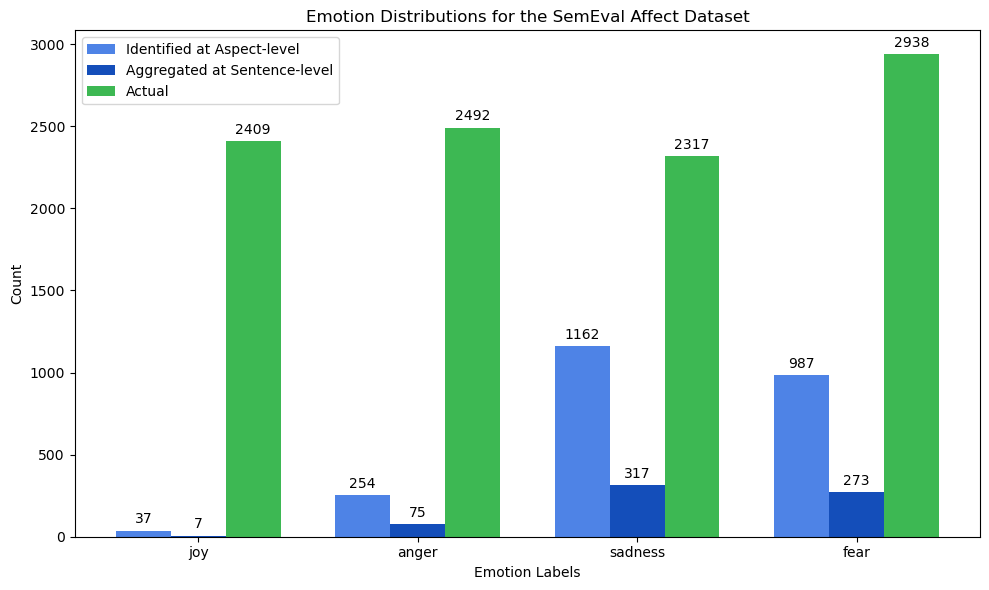

In [322]:
import matplotlib.pyplot as plt
import numpy as np


print(f"Model trained on {model_path}") 
print("---------------")
print("  ")

print("ASPECT TERM EXTRACTION VALIDATION")
print(f"\nModel performance for SemEval Restaurants All:\t\tPrecision: {metrics_rest_all['Precision']}\tRecall: {metrics_rest_all['Recall']}\t\tF1: {metrics_rest_all['F1 Score']}")
print(f"\nModel performance for SemEval Laptop 2014:\t\tPrecision: {metrics_lap14['Precision']}\tRecall: {metrics_lap14['Recall']}\t\tF1: {metrics_lap14['F1 Score']}")
# print(f"\nModel performance for SemEval Restaurants 2014:\t\tPrecision: {metrics_rest14['Precision']}\tRecall: {metrics_rest14['Recall']}\t\tF1: {metrics_rest14['F1 Score']}")
print("---------------")
print("  ")

print("ASPECT EMOTION CLASSIFICATION VALIDATION")
print(f"Aspect-level Emotions found by the Model in the Affect SemEval 2018 dataset:\t\t{count_emotion_words1(df_affect)}")
print(f"Sentence-level Emotions found by the Model in the Affect SemEval 2018 dataset:\t\t{count_emotion_words2(filtered_df_affect, 'aspect_emotions')}")
print(f"Actual Sentence-Level Emotions in the Affect SemEval 2018 dataset:\t\t\t{count_emotion_words2(filtered_df_affect, 'Affect Dimension')}")
print("   ")

# Print the results
print(f"Overall Accuracy: {round(accuracy,3)}")
print(f"Overall Precision: {round(precision,3)}")
print(f"Overall Recall: {round(recall,3)}")
print(f"Overall F1 Score: {round(f1,3)}")
print("   ")

# Print individual metrics
for emotion, p, r, f in zip(['joy', 'anger', 'sadness', 'fear'], precision_individual, recall_individual, f1_individual):
    print(f"\nMetrics for {emotion.capitalize()}:")
    print(f"Precision: {round(p,3)}")
    print(f"Recall: {round(r,3)}")
    print(f"F1 Score: {round(f,3)}")
    print("   ")



# Define a file name for the text output
output_text_file = path + 'validation_stats.txt'
print(output_text_file)

# Open the file in write mode
with open(output_text_file, 'w') as f:
    # Redirect prints to the file
    f.write(f"Model trained on {model_path}\n")
    f.write("---------------\n\n")
    f.write("ASPECT TERM EXTRACTION VALIDATION\n")
    f.write(f"\nModel performance for SemEval Restaurants All:\t\tPrecision: {metrics_rest_all['Precision']}\tRecall: {metrics_rest_all['Recall']}\t\tF1: {metrics_rest_all['F1 Score']}\n")
    f.write(f"\nModel performance for SemEval Laptop 2014:\t\tPrecision: {metrics_lap14['Precision']}\tRecall: {metrics_lap14['Recall']}\t\tF1: {metrics_lap14['F1 Score']}\n")
    # f.write(f"\nModel performance for SemEval Restaurants 2014:\t\tPrecision: {metrics_rest14['Precision']}\tRecall: {metrics_rest14['Recall']}\t\tF1: {metrics_rest14['F1 Score']}\n")
    f.write("---------------\n\n")
    f.write("ASPECT EMOTION CLASSIFICATION VALIDATION\n")
    f.write(f"Aspect-level Emotions found by the Model in the Affect SemEval 2018 dataset:\t\t{count_emotion_words1(df_affect)}\n")
    f.write(f"Sentence-level Emotions found by the Model in the Affect SemEval 2018 dataset:\t\t{count_emotion_words2(filtered_df_affect, 'aspect_emotions')}\n")
    f.write(f"Actual Sentence-Level Emotions in the Affect SemEval 2018 dataset:\t\t\t{count_emotion_words2(filtered_df_affect, 'Affect Dimension')}\n\n")
    f.write(f"Overall Accuracy: {round(accuracy, 3)}\n")
    f.write(f"Overall Precision: {round(precision, 3)}\n")
    f.write(f"Overall Recall: {round(recall, 3)}\n")
    f.write(f"Overall F1 Score: {round(f1, 3)}\n\n")

    # Print individual metrics
    for emotion, p, r, f1 in zip(['joy', 'anger', 'sadness', 'fear'], precision_individual, recall_individual, f1_individual):
        f.write(f"\nMetrics for {emotion.capitalize()}:\n")
        f.write(f"Precision: {round(p, 3)}\n")
        f.write(f"Recall: {round(r, 3)}\n")
        f.write(f"F1 Score: {round(f1, 3)}\n")
        f.write("\n")




# create chart showing distributions

# Normalized emotion labels to ensure consistency
emotion_labels = ['joy', 'anger', 'sadness', 'fear']

# Mapping to standard labels
label_mapping = {
    'HAPPINESS': 'joy',
    'ANGER': 'anger',
    'SADNESS': 'sadness',
    'FEAR': 'fear',
    'O': 'None',  # This can be ignored for now unless 'None' needs to be included in the plot
}

# Standardizing the counts according to the normalized labels
def standardize_counts(counter, label_mapping, emotion_labels):
    standardized_counts = []
    for emotion in emotion_labels:
        # Normalize label using the mapping
        standard_label = label_mapping.get(emotion.upper(), emotion)
        # Fetch the count from the counter, considering both the original and mapped label
        count = counter.get(emotion, 0) + counter.get(emotion.upper(), 0) + counter.get(standard_label.upper(), 0)
        print(f"Mapping '{emotion.upper()}' or '{standard_label.upper()}' to '{standard_label}' with count: {count}")
        standardized_counts.append(count)
    return standardized_counts

# Standardize counts for all conditions
standardized_counts1 = standardize_counts(count_emotion_words1(df_affect), label_mapping, emotion_labels)
standardized_counts2 = standardize_counts(count_emotion_words2(filtered_df_affect, 'aspect_emotions'), label_mapping, emotion_labels)
standardized_counts3 = standardize_counts(count_emotion_words2(filtered_df_affect, 'Affect Dimension'), label_mapping, emotion_labels)

counts1 = [count_emotion_words1(df_affect)['HAPPINESS'], count_emotion_words1(df_affect)['ANGER'], count_emotion_words1(df_affect)['SADNESS'], count_emotion_words1(df_affect)['FEAR']]
counts2 = [count_emotion_words2(filtered_df_affect, 'aspect_emotions')['joy'], count_emotion_words2(filtered_df_affect, 'aspect_emotions')['anger'], count_emotion_words2(filtered_df_affect, 'aspect_emotions')['sadness'], count_emotion_words2(filtered_df_affect, 'aspect_emotions')['fear']]
counts3 = [count_emotion_words2(filtered_df_affect, 'Affect Dimension')['joy'], count_emotion_words2(filtered_df_affect, 'Affect Dimension')['anger'], count_emotion_words2(filtered_df_affect, 'Affect Dimension')['sadness'], count_emotion_words2(filtered_df_affect, 'Affect Dimension')['fear']]

# Set up bar width and positions
bar_width = 0.25
index = np.arange(len(emotion_labels))

# Custom colors for each group
color1 = '#4e83e6'  # Aspect-level (light blue)
color2 = '#144eba'  # Sentence-level (dark blue)
color3 = '#3db853'  # Actual (Blue)

# Plotting the bars with custom colors
fig, ax = plt.subplots(figsize=(10, 6))

bars1 = ax.bar(index, counts1, bar_width, label='Identified at Aspect-level', color=color1)
bars2 = ax.bar(index + bar_width, counts2, bar_width, label='Aggregated at Sentence-level', color=color2)
bars3 = ax.bar(index + 2 * bar_width, counts3, bar_width, label='Actual', color=color3)

# Add labels, title, and legend
ax.set_xlabel('Emotion Labels')
ax.set_ylabel('Count')
ax.set_title('Emotion Distributions for the SemEval Affect Dataset')
ax.set_xticks(index + bar_width)
ax.set_xticklabels(emotion_labels)
ax.legend()

# Add counts on top of the bars
def add_bar_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{int(height)}', 
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

add_bar_labels(bars1)
add_bar_labels(bars2)
add_bar_labels(bars3)

# Save the figure as a PNG file
output_image_file = path + 'emotion_distributions.png'
plt.savefig(output_image_file)

# Display the plot
plt.tight_layout()
plt.show()
